In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import os
import random
import time

from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torch.optim import Adam, SGD

# !pip install torchmetrics
# import torchmetrics

!pip install torchinfo
from torchinfo import summary

In [2]:
#For ensuaring the reproducible results
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
image_size = 512
batch_size = 16

In [4]:
df_train = pd.read_csv('../input/fgvc-aircraft/train.csv')
df_val = pd.read_csv('../input/fgvc-aircraft/val.csv')
df_test = pd.read_csv('../input/fgvc-aircraft/test.csv')
df_train.head()

filename  Classes  Labels
0  1025794.jpg  707-320       0
1  1340192.jpg  707-320       0
2  0056978.jpg  707-320       0
3  0698580.jpg  707-320       0
4  0450014.jpg  707-320       0

In [5]:
tpath = "../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images"
df_train = df_train.assign(Paths = tpath + "/" + df_train["filename"])
df_val = df_val.assign(Paths = tpath + "/" + df_val["filename"])
df_test = df_test.assign(Paths = tpath + "/" + df_test["filename"])

def get_data(df):
    data = []
    for idx in range(len(df)):
        data.append((str(df.at[idx,"Paths"]),df.at[idx,"Labels"]))
    return data

data_train = get_data(df_train)
data_val = get_data(df_val)
data_test = get_data(df_test)
print(data_train[10])
print(data_train[100])
print(len(data_train))
print(len(data_val))
print(len(data_test))


('../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/0951982.jpg', 0)
('../input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images/1899111.jpg', 3)
3334
3333
3333


In [6]:
# #Get the infos about the size of the data
# for x, y in data_train:
#     example_image = cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)
#     print(example_image.shape)

##The quality of most of the pictures are quite good (approximately around (512, 1024,3)). So we're going to convert the pic to 512x512x3

In [7]:
#We notice that there'are 20-pixels high authorship informations (according to the dataset's informations)
example_image = cv2.cvtColor(cv2.imread(data_train[150][0]), cv2.COLOR_BGR2RGB)
plt.imshow(example_image)

In [8]:
#Crop the banner (authorship information) (20 pixels high at the bottom)
example_image = cv2.cvtColor(cv2.imread(data_train[150][0]), cv2.COLOR_BGR2RGB)
example_image
plt.imshow(example_image[0:-20, :])

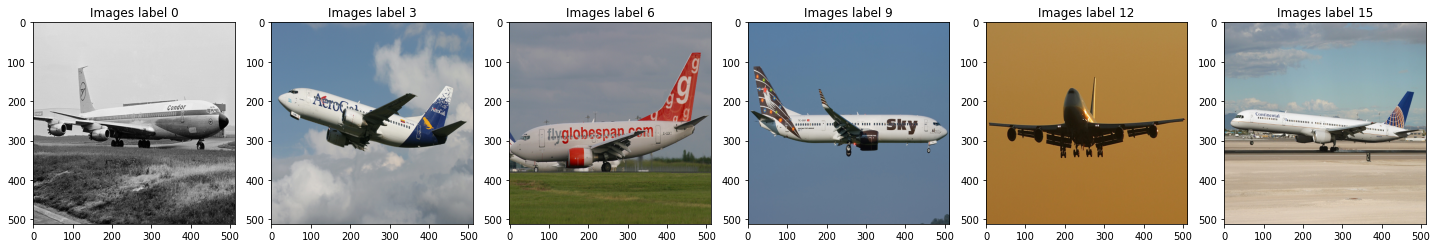

In [9]:
#Vision about the data
num_images = 6
figures,axis = plt.subplots(1,num_images,figsize=(20,20))

for idx in range(num_images):
  example_image = cv2.cvtColor(cv2.imread(data_train[100*idx][0]), cv2.COLOR_BGR2RGB)

    #Remove the banner (authorship information)
  example_image = example_image[0:-20,:]

  example_image = cv2.resize(example_image, (image_size,image_size),interpolation=cv2.INTER_CUBIC)

  axis[idx].set_title("Images label " + str(data_train[100*idx][1]))
  axis[idx].imshow(example_image)


#OpenCV uses BGR while mathplotlib uses RGB
plt.tight_layout()
plt.show()

In [10]:
class LoadDataset(Dataset):
    def __init__(self, data, transform, image_size):
        self.data = data
        self.len = len(self.data)
        self.transform = transform
        self.size = image_size

        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        image_path, label = self.data[idx]

        img = np.array(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
        
        #Crop the banner (20-pixels high)
        img = img[0:-20,:]
        
        resized_img = cv2.resize(img, (self.size,self.size),interpolation =cv2.INTER_CUBIC).astype("float32")/255
        
        #From BGR (default in OpenCV), return the RGB image
        image_tensor = torch.from_numpy(np.transpose(resized_img,(2,0,1)))
        
        #Return the transformed images and the label
        
        return self.transform(image_tensor), label

In [11]:
#Transform
transformed = transforms.Compose([
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])    #From ImageNet  
                    ])

#Device

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [12]:
train_set = LoadDataset(data=data_train, transform=transformed, image_size=image_size)
val_set = LoadDataset(data=data_val, transform=transformed, image_size=image_size)
test_set = LoadDataset(data=data_test, transform=transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]), image_size=image_size)

In [13]:
# for x,y in train_set:
#     print(x,y)
#     break
# for x,y in val_set:
#     print(x,y)
#     break

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size = batch_size, shuffle = True, num_workers =2
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size = batch_size, shuffle = True, num_workers =2
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size = batch_size, shuffle = True
)

In [15]:
class ConvNet(nn.Module):
    def __init__(self,num_classes):
        super(ConvNet,self).__init__()
         
        self.conv1=nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5,stride=1, padding=0)
        self.mish=nn.Mish()        
        self.pool=nn.MaxPool2d(kernel_size=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4=nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3,stride=1, padding = 0)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5=nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=0)
        self.bn5 = nn.BatchNorm2d(512)
        self.flat = nn.Flatten()
        self.fc1=nn.Linear(512 * 14 * 14,256)
        self.dropout = nn.Dropout(0.2)
        self.fc2=nn.Linear(256,100)

        
        
        
        #Feed forwad function
        
    def forward(self,input):
      output = self.pool(self.mish(self.bn1(self.conv1(input))))
      output = self.pool(self.mish(self.bn2(self.conv2(output))))
      output = self.pool(self.mish(self.bn3(self.conv3(output))))
      output = self.pool(self.mish(self.bn4(self.conv4(output))))
      output = self.pool(self.mish(self.bn5(self.conv5(output))))

      output=self.flat(output)
      output=self.dropout(self.mish(self.fc1(output)))
      output=self.fc2(output)
    
    
         
      return output
   

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model=ConvNet(num_classes=100).to(device)

summary(model, input_size=(16, 3, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [16, 100]                 --
├─Conv2d: 1-1                            [16, 32, 508, 508]        2,432
├─BatchNorm2d: 1-2                       [16, 32, 508, 508]        64
├─Mish: 1-3                              [16, 32, 508, 508]        --
├─MaxPool2d: 1-4                         [16, 32, 254, 254]        --
├─Conv2d: 1-5                            [16, 64, 252, 252]        18,496
├─BatchNorm2d: 1-6                       [16, 64, 252, 252]        128
├─Mish: 1-7                              [16, 64, 252, 252]        --
├─MaxPool2d: 1-8                         [16, 64, 126, 126]        --
├─Conv2d: 1-9                            [16, 128, 124, 124]       73,856
├─BatchNorm2d: 1-10                      [16, 128, 124, 124]       256
├─Mish: 1-11                             [16, 128, 124, 124]       --
├─MaxPool2d: 1-12                        [16, 128, 62, 62]         --
├─

In [17]:
def train_epoch(net, dataloader, lr = 0.01, optimizer=None, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  net.train()
  total_loss, acc, count = 0,0,0
  for features, labels in dataloader:
    optimizer.zero_grad()
    lbls = labels.to(device)
    out = net(features.to(device))
    loss = loss_fn(out, lbls) #cross_entropy(out, labels)
    loss.backward()
    optimizer.step()
    total_loss +=loss
    _, predicted = torch.max(out,1)
    acc +=(predicted == lbls).sum()
    count += len(labels)
  
  return total_loss.item()/count, acc.item()/count

def validate(net, dataloader, loss_fn = nn.NLLLoss()):
  net.eval()
  count, acc, loss = 0,0,0
  with torch.no_grad():
    for features, labels in dataloader:
      lbls = labels.to(device)
      out = net(features.to(device))
      loss += loss_fn(out,lbls)
      pred = torch.max(out,1)[1]
      acc += (pred==lbls).sum()
      count += len(labels)

  return loss.item()/count, acc.item()/count

def train(net, train_loader, val_loader, optimizer = None, lr = 0.001, epochs = 10, loss_fn = nn.NLLLoss()):
  optimizer = optimizer or torch.optim.Adam(net.parameters(), lr = lr)
  best_accuracy=0.0
  res = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
  for ep in range(epochs):
    since = time.time()
    
    
    tl,ta = train_epoch(net,train_loader, optimizer = optimizer, lr=lr, loss_fn = loss_fn)
    vl, va = validate(net, val_loader, loss_fn = loss_fn)
    print(f"Epoch {ep}, Train acc = {ta:.3f}, Val acc = {va:.3f}, Train loss = {tl:.3f}, Val loss = {vl:.3f}")
    res["train_loss"].append(tl)
    res["train_acc"].append(ta)
    res["val_loss"].append(vl)
    res["val_acc"].append(va)
    if va>best_accuracy:
        torch.save(net,"/kaggle/working/BestModel.pt")
        best_accuracy=va
        
        
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return res
def plot_results(hist):
  plt.figure(figsize = (15,15))
  plt.subplot(1,2,1)
  plt.plot(hist["train_acc"], label = "Training acc")
  plt.plot(hist["val_acc"], label = "Validation acc")
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(hist["train_loss"], label = "Training loss")
  plt.plot(hist["val_loss"], label = "Validation loss")
  plt.legend()

Epoch 0, Train acc = 0.016, Val acc = 0.026, Train loss = 0.291, Val loss = 0.284
2m 45s
Epoch 1, Train acc = 0.025, Val acc = 0.038, Train loss = 0.281, Val loss = 0.278
2m 37s
Epoch 2, Train acc = 0.041, Val acc = 0.033, Train loss = 0.276, Val loss = 0.278
2m 31s
Epoch 3, Train acc = 0.046, Val acc = 0.053, Train loss = 0.271, Val loss = 0.271
2m 31s
Epoch 4, Train acc = 0.066, Val acc = 0.029, Train loss = 0.264, Val loss = 0.302
2m 36s
Epoch 5, Train acc = 0.069, Val acc = 0.072, Train loss = 0.258, Val loss = 0.260
2m 29s
Epoch 6, Train acc = 0.084, Val acc = 0.058, Train loss = 0.249, Val loss = 0.260
2m 37s
Epoch 7, Train acc = 0.107, Val acc = 0.091, Train loss = 0.237, Val loss = 0.243
2m 38s
Epoch 8, Train acc = 0.134, Val acc = 0.105, Train loss = 0.224, Val loss = 0.234
2m 40s
Epoch 9, Train acc = 0.177, Val acc = 0.123, Train loss = 0.210, Val loss = 0.233
2m 40s
Epoch 10, Train acc = 0.179, Val acc = 0.155, Train loss = 0.197, Val loss = 0.214
2m 41s
Epoch 11, Train acc 

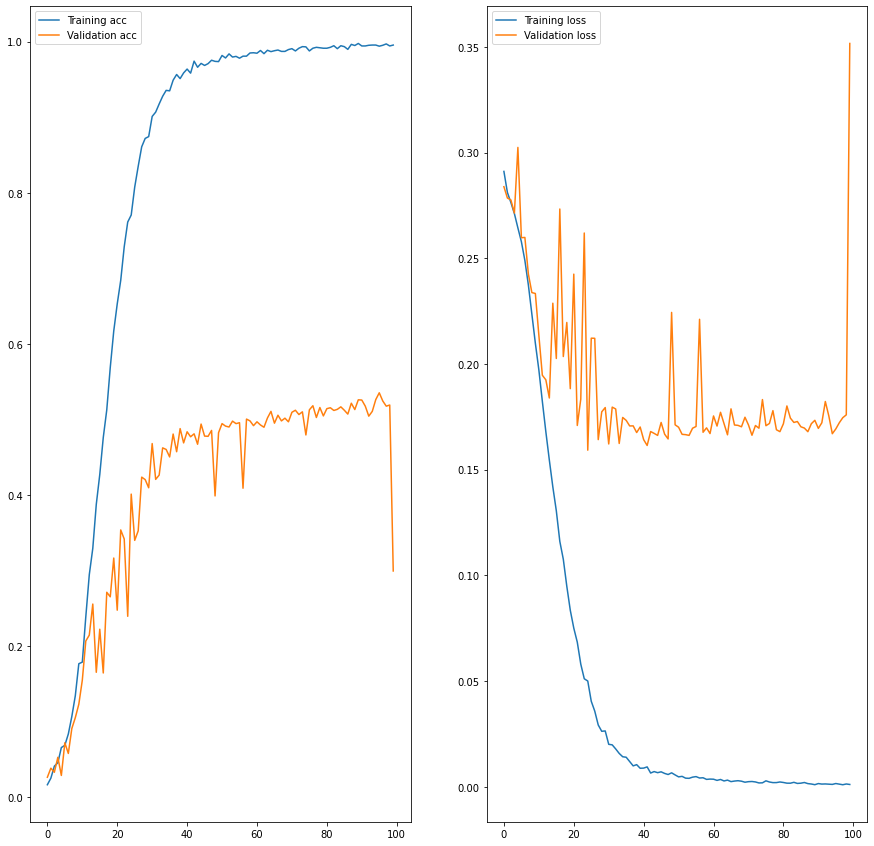

In [18]:
hist = train(model,train_loader,val_loader,optimizer = SGD(model.parameters(),lr=0.01), epochs=100, loss_fn = nn.CrossEntropyLoss())
plot_results(hist)

In [19]:
loss_test, acc_test =  validate(model, test_loader, loss_fn = nn.CrossEntropyLoss())

In [20]:
print(f"Loss on test set is {loss_test}, accuracy on test set {acc_test*100}  %")

Loss on test set is 0.3501553768658116, accuracy on test set 29.792979297929794  %


In [21]:
# from sklearn.metrics import confusion_matrix
# import seaborn as sn
# import pandas as pd

# y_pred = []
# y_true = []

# # iterate over test data
# for inputs, labels in test_loader:
#     labels = labels.to(device)
#     output = model(inputs.to(device)) # Feed Network

#     output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
#     y_pred.extend(output) # Save Prediction

#     labels = labels.data.cpu().numpy()
#     y_true.extend(labels) # Save Truth

# # constant for classes
# classes = [i for i in range(0,100)]

# # Build confusion matrix
# cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *100, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (12,7))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')